# CNN on CIFR 

Steps :
1.  Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
2.  You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy. 
3.  You cannot use Dense Layers (also called fully connected layers), or DropOut.
4.  You MUST use Image Augmentation Techniques.
5.  You cannot use an already trained model as a beginning points, you have to initilize as your own
6.  You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
7.  You cannot use test images for training the model.
8.  You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
9.  You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
10. You cannot have more than 1 Million parameters in total
11. You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc. 
12. You can use any optimization algorithm you need. 
13. You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch. 

In [2]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model

In [2]:
%load_ext tensorboard

In [4]:
filepath="Model/weights-2{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')

In [5]:
log_dir="logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

In [6]:
datagen = ImageDataGenerator(rotation_range=15,
                               width_shift_range=5./32,
                               height_shift_range=5./32,
                               horizontal_flip=True)

In [7]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 300
l = 16
num_filter = 12
compression = 0.58
dropout_rate = 0
weight_decay=1e-4
learning_rate=0.1

In [8]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train/=255
X_test/=255

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)



In [9]:
X_train.shape

(50000, 32, 32, 3)

In [10]:
X_test.shape

(10000, 32, 32, 3)

In [11]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    global weight_decay
    temp = input
    for _ in range(l): 
        inter_channel = num_filter * 4
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_1_1 = layers.Conv2D(inter_channel, (1, 1), kernel_initializer='he_normal', padding='same', use_bias=False,
                   kernel_regularizer=l2(weight_decay))(relu)              
        BatchNorm = layers.BatchNormalization(epsilon=1.1e-5)(Conv2D_1_1)
        relu = layers.Activation('relu')(BatchNorm)              

        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), kernel_initializer='he_normal', use_bias=False, padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    global weight_decay
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output


In [12]:

input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter*2, (3,3), use_bias=False ,padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(input)

First_Block = denseblock(First_Conv2D, num_filter*2, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

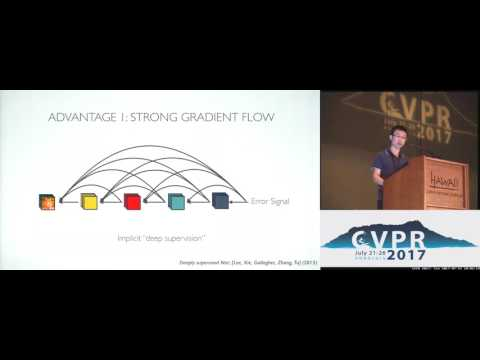

In [17]:
#https://arxiv.org/pdf/1608.06993.pdf
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo(id='-W6y8xnd--U', width=600)

In [13]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 24)   648         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 24)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 24)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

__________________________________________________________________________________________________
conv2d_61 (Conv2D)              (None, 16, 16, 6)    2592        activation_60[0][0]              
__________________________________________________________________________________________________
concatenate_29 (Concatenate)    (None, 16, 16, 90)   0           concatenate_28[0][0]             
                                                                 conv2d_61[0][0]                  
__________________________________________________________________________________________________
batch_normalization_61 (BatchNo (None, 16, 16, 90)   360         concatenate_29[0][0]             
__________________________________________________________________________________________________
activation_61 (Activation)      (None, 16, 16, 90)   0           batch_normalization_61[0][0]     
__________________________________________________________________________________________________
conv2d_62 

batch_normalization_131 (BatchN (None, 4, 4, 102)    408         concatenate_63[0][0]             
__________________________________________________________________________________________________
activation_131 (Activation)     (None, 4, 4, 102)    0           batch_normalization_131[0][0]    
__________________________________________________________________________________________________
average_pooling2d_3 (AveragePoo (None, 2, 2, 102)    0           activation_131[0][0]             
__________________________________________________________________________________________________
flatten (Flatten)               (None, 408)          0           average_pooling2d_3[0][0]        
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           4090        flatten[0][0]                    
Total params: 650,690
Trainable params: 633,150
Non-trainable params: 17,540
________________________________

In [19]:
plot_model(model, 'model_1.png',show_shapes=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.634478 to fit



In [20]:
# determine Loss function and Optimizer
sgd = SGD(lr=learning_rate, decay=0.0001, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])


In [21]:
datagen.fit(X_train, augment=True)

steps_per_epoch = 100    
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
              steps_per_epoch=steps_per_epoch,
              epochs=100,
              verbose=1,      
               validation_data=(X_test, y_test),
              callbacks=[checkpoint,tensorboard_callback])      


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
  1/100 [..............................] - ETA: 23s - loss: 3.3706 - accuracy: 0.0625WARNING:tensorflow:From C:\Users\Manali\Anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
100/100 [==============================] - ETA: 0s - loss: 2.8606 - accuracy: 0.2487 
Epoch 00001: val_accuracy improved from -inf to 0.11290, saving model to Model\weights-01-0.1129.hdf5
100/100 [==============================] - 2242s 22s/step - loss: 2.8606 - accuracy: 0.2487 - val_loss: 308.2199 - val_accuracy: 0.1129
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 2.5280 - accuracy: 0.3446 
Epoch 00002: val_accuracy improved from 0.11290 to 0.32570, saving model to Model\weights-02-0.3257.hdf5
100/100 [========

Epoch 26/100
100/100 [==============================] - ETA: 0s - loss: 1.2679 - accuracy: 0.6773 
Epoch 00026: val_accuracy did not improve from 0.66220
100/100 [==============================] - 2296s 23s/step - loss: 1.2679 - accuracy: 0.6773 - val_loss: 1.4314 - val_accuracy: 0.6312
Epoch 27/100
100/100 [==============================] - ETA: 0s - loss: 1.2606 - accuracy: 0.6777 
Epoch 00027: val_accuracy did not improve from 0.66220
100/100 [==============================] - 2349s 23s/step - loss: 1.2606 - accuracy: 0.6777 - val_loss: 1.7496 - val_accuracy: 0.5721
Epoch 28/100
100/100 [==============================] - ETA: 0s - loss: 1.2412 - accuracy: 0.6791 
Epoch 00028: val_accuracy did not improve from 0.66220
100/100 [==============================] - 2452s 25s/step - loss: 1.2412 - accuracy: 0.6791 - val_loss: 2.0445 - val_accuracy: 0.5446
Epoch 29/100
100/100 [==============================] - ETA: 0s - loss: 1.2249 - accuracy: 0.6804 
Epoch 00029: val_accuracy did not imp

100/100 [==============================] - 2214s 22s/step - loss: 0.8531 - accuracy: 0.7773 - val_loss: 1.0932 - val_accuracy: 0.7151
Epoch 54/100
100/100 [==============================] - ETA: 0s - loss: 0.8449 - accuracy: 0.7771 
Epoch 00054: val_accuracy did not improve from 0.75220
100/100 [==============================] - 2207s 22s/step - loss: 0.8449 - accuracy: 0.7771 - val_loss: 1.2398 - val_accuracy: 0.6827
Epoch 55/100
100/100 [==============================] - ETA: 0s - loss: 0.8499 - accuracy: 0.7741 
Epoch 00055: val_accuracy improved from 0.75220 to 0.75290, saving model to Model\weights-55-0.7529.hdf5
100/100 [==============================] - 2194s 22s/step - loss: 0.8499 - accuracy: 0.7741 - val_loss: 0.9256 - val_accuracy: 0.7529
Epoch 56/100
100/100 [==============================] - ETA: 0s - loss: 0.8369 - accuracy: 0.7814 
Epoch 00056: val_accuracy improved from 0.75290 to 0.75340, saving model to Model\weights-56-0.7534.hdf5
100/100 [===========================

In [26]:
# Save the trained weights in to .h5 format
model.save_weights("Model\DNST_model_1.h5")
print("Saved model to disk")

Saved model to disk


In [6]:
#%tensorboard --logdir logs1/

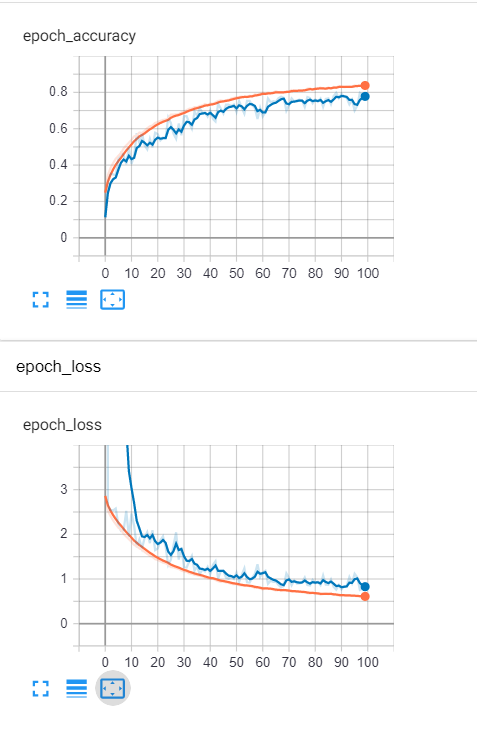

In [8]:
from PIL import Image
Image.open("model_1_loss_acc.png")

In [15]:
datagen.fit(X_train, augment=True)
model = Model(inputs=[input], outputs=[output])
model.load_weights("Model\DNST_model_1.h5")
sgd = SGD(lr=learning_rate, decay=0.0001, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
             optimizer=sgd,
              metrics=['accuracy'])

In [16]:
steps_per_epoch = 100    
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
              steps_per_epoch=steps_per_epoch,
              epochs=100,
              verbose=1,  
               validation_data=(X_test, y_test),
              callbacks=[checkpoint,tensorboard_callback]) 

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
  1/100 [..............................] - ETA: 3s - loss: 0.4013 - accuracy: 0.8750WARNING:tensorflow:From C:\Users\Manali\Anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
100/100 [==============================] - ETA: 0s - loss: 0.4663 - accuracy: 0.8832 
Epoch 00001: val_accuracy improved from -inf to 0.79690, saving model to Model\weights-201-0.7969.hdf5
100/100 [==============================] - 2510s 25s/step - loss: 0.4663 - accuracy: 0.8832 - val_loss: 0.7900 - val_accuracy: 0.7969
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.4879 - accuracy: 0.8775 
Epoch 00002: val_accuracy improved from 0.79690 to 0.82210, saving model to Model\weights-202-0.8221.hdf5
100/100 [=========

100/100 [==============================] - ETA: 0s - loss: 0.4104 - accuracy: 0.9022 
Epoch 00054: val_accuracy did not improve from 0.87000
100/100 [==============================] - 2174s 22s/step - loss: 0.4104 - accuracy: 0.9022 - val_loss: 0.8733 - val_accuracy: 0.7896
Epoch 55/100
100/100 [==============================] - ETA: 0s - loss: 0.4135 - accuracy: 0.9007 
Epoch 00055: val_accuracy did not improve from 0.87000
100/100 [==============================] - 2487s 25s/step - loss: 0.4135 - accuracy: 0.9007 - val_loss: 0.6772 - val_accuracy: 0.8259
Epoch 56/100
100/100 [==============================] - ETA: 0s - loss: 0.4166 - accuracy: 0.8993 
Epoch 00056: val_accuracy did not improve from 0.87000
100/100 [==============================] - 3081s 31s/step - loss: 0.4166 - accuracy: 0.8993 - val_loss: 0.6772 - val_accuracy: 0.8307
Epoch 57/100
100/100 [==============================] - ETA: 0s - loss: 0.3976 - accuracy: 0.9087 
Epoch 00057: val_accuracy did not improve from 0.8

In [17]:
# Save the trained weights in to .h5 format
model.save_weights("Model\DNST_model_2.h5")
print("Saved model to disk")

Saved model to disk


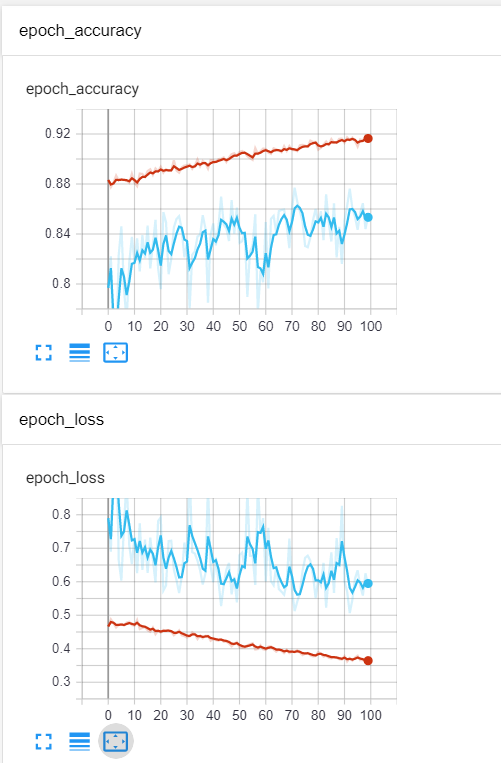

In [9]:
from PIL import Image
Image.open("model_2_loss_acc.png")

In [13]:
datagen.fit(X_train, augment=True)
model = Model(inputs=[input], outputs=[output])
model.load_weights("Model\DNST_model_2.h5")

sgd = SGD(lr=learning_rate, decay=0.001, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
             optimizer=sgd,
              metrics=['accuracy'])

In [15]:
steps_per_epoch = 100    
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
              steps_per_epoch=steps_per_epoch,
              epochs=100,
              verbose=1,  
               validation_data=(X_test, y_test),
              callbacks=[checkpoint,tensorboard_callback])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
  1/100 [..............................] - ETA: 11s - loss: 0.3670 - accuracy: 0.8906WARNING:tensorflow:From C:\Users\Manali\Anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
100/100 [==============================] - ETA: 0s - loss: 0.4218 - accuracy: 0.8971 
Epoch 00001: val_accuracy improved from -inf to 0.78250, saving model to Model\weights-201-0.7825.hdf5
100/100 [==============================] - 2427s 24s/step - loss: 0.4218 - accuracy: 0.8971 - val_loss: 0.9309 - val_accuracy: 0.7825
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.4525 - accuracy: 0.8871 
Epoch 00002: val_accuracy did not improve from 0.78250
100/100 [==============================] - 2289s 23s/step - loss: 0.

100/100 [==============================] - ETA: 0s - loss: 0.2588 - accuracy: 0.9464 
Epoch 00054: val_accuracy did not improve from 0.89540
100/100 [==============================] - 2207s 22s/step - loss: 0.2588 - accuracy: 0.9464 - val_loss: 0.5123 - val_accuracy: 0.8839
Epoch 55/100
100/100 [==============================] - ETA: 0s - loss: 0.2628 - accuracy: 0.9463 
Epoch 00055: val_accuracy did not improve from 0.89540
100/100 [==============================] - 2205s 22s/step - loss: 0.2628 - accuracy: 0.9463 - val_loss: 0.4887 - val_accuracy: 0.8895
Epoch 56/100
100/100 [==============================] - ETA: 0s - loss: 0.2552 - accuracy: 0.9480 
Epoch 00056: val_accuracy did not improve from 0.89540
100/100 [==============================] - 2209s 22s/step - loss: 0.2552 - accuracy: 0.9480 - val_loss: 0.4926 - val_accuracy: 0.8891
Epoch 57/100
100/100 [==============================] - ETA: 0s - loss: 0.2609 - accuracy: 0.9452 
Epoch 00057: val_accuracy did not improve from 0.8

Epoch 82/100
100/100 [==============================] - ETA: 0s - loss: 0.2201 - accuracy: 0.9566 
Epoch 00082: val_accuracy did not improve from 0.90500
100/100 [==============================] - 2202s 22s/step - loss: 0.2201 - accuracy: 0.9566 - val_loss: 0.4819 - val_accuracy: 0.8922
Epoch 83/100
100/100 [==============================] - ETA: 0s - loss: 0.2326 - accuracy: 0.9530 
Epoch 00083: val_accuracy did not improve from 0.90500
100/100 [==============================] - 2201s 22s/step - loss: 0.2326 - accuracy: 0.9530 - val_loss: 0.4894 - val_accuracy: 0.8901
Epoch 84/100
100/100 [==============================] - ETA: 0s - loss: 0.2281 - accuracy: 0.9517 
Epoch 00084: val_accuracy did not improve from 0.90500
100/100 [==============================] - 2196s 22s/step - loss: 0.2281 - accuracy: 0.9517 - val_loss: 0.4846 - val_accuracy: 0.8952
Epoch 85/100
100/100 [==============================] - ETA: 0s - loss: 0.2297 - accuracy: 0.9534 
Epoch 00085: val_accuracy did not imp

In [1]:
%tensorboard --logdir logs/

UsageError: Line magic function `%tensorboard` not found.


In [16]:
# Test the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 157s 501ms/step - loss: 0.4620 - accuracy: 0.8974
Test loss: 0.46195247769355774
Test accuracy: 0.8974000215530396


In [17]:
# Save the trained weights in to .h5 format
model.save_weights("Model\DNST_model.h5")
print("Saved model to disk")

Saved model to disk


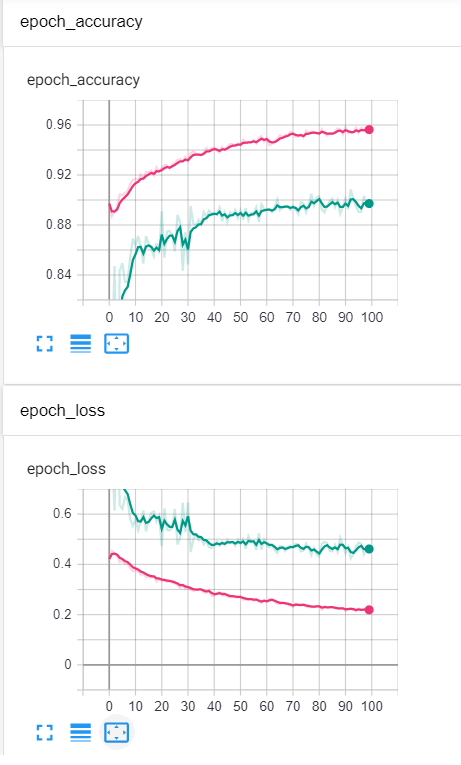

In [10]:
from PIL import Image
Image.open("model_3_loss_acc.png")

## Loading the best Model

In [22]:
model = Model(inputs=[input], outputs=[output])
model.load_weights("Model\weights-293-0.9085.hdf5")

sgd = SGD(lr=learning_rate, decay=0.001, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
             optimizer=sgd,
              metrics=['accuracy'])

In [23]:
# Test the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 304s 971ms/step - loss: 0.4238 - accuracy: 0.9085
Test loss: 0.4238123893737793
Test accuracy: 0.9085000157356262


Observation : During  training the model that I have created using DenseNet with 300 epochs, the model did achieve the testaccuracy of 90+ at the 298th epoc and went to 89.74 at the 300th epoc. 
As the model has the latest weights saved from 300th epoc, the test accuracy is shown as 89.74. 